In [1]:
import numpy as np
import pandas as pd
import glob, os
from itertools import chain, product, permutations
from nilearn import image, plotting, masking
from scipy.stats import pearsonr,ttest_1samp
from scipy import stats
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import community as community_louvain # pip install python-louvain
%matplotlib inline
np.warnings.filterwarnings('ignore')

### Parse resdisual activity time series into epoch-wise FC matrices (for each participant)

In [4]:
# -------------------
# Helpfer functions
# -------------------
def _separate_epochs(activity_data, epoch_list):
    """ create data epoch by epoch

    Separate data into conditions of interest specified in epoch_list

    Parameters
    ----------
    activity_data: list of 2D array in shape [nVoxels, nTRs]
        the masked activity data organized in voxel*TR formats of all subjects
    epoch_list: list of 3D array in shape [condition, nEpochs, nTRs]
        specification of epochs and conditions
        assuming all subjects have the same number of epochs
        len(epoch_list) equals the number of subjects

    Returns
    -------
    raw_data: list of 2D array in shape [nParcels, timepoints (36*16)]
        the data organized in epochs
        len(raw_data) equals 48 (24 subjects, 2 conditions for each subject for retrieve vs. perceive.)
    labels: list of 1D array
        the condition labels of the epochs
        len(labels) labels equals the number of epochs
    """
    raw_data = []
    labels = []
    for sid in range(len(epoch_list)): #for a given subject
        epoch = epoch_list[sid] # get their npy array
        for cond in range(epoch.shape[0]): # for a given condition
            # for each condition
            sub_epoch = epoch[cond, :, :]
            ts = np.zeros(1956)
            for eid in range(epoch.shape[1]):
                r = np.sum(sub_epoch[eid, :])
                if r > 0:   # there is an epoch in this condition
                    # collapse all epoch of a condition to a single time series
                    ts[sub_epoch[eid, :] == 1] = 1
            ts = ts.astype(np.bool)
            mat_cond = activity_data[sid][:,ts]
            mat_cond = np.ascontiguousarray(mat_cond)
            raw_data.append(mat_cond)
            labels.append(cond)

    return raw_data, labels

def divide_into_epoch(ts, epoch_length): 
    # looping till length l 
    for i in range(0, len(ts), epoch_length):  
        yield ts[i:i + epoch_length] 

# reorganize: 
def reorder_cor_mat(cormat):
    # Original column/row order, this is based on the size of the ROI. 
    roi_order = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
    # New column/row order, this is based on the community structure. 
    new_roi_order = ["mPFC","rAG","Precuneus(Superior)","lAG1","PCC","MTG","lAG2","rITG","rLOC","rPFC","lPFC1","SFG","lPFC2",'lLOC',"Precuenus(Inferior)2","Precuneus(inferior)"]
    
    # turn original np into df
    df = pd.DataFrame(cormat, columns = roi_order, index = roi_order)
   
    new_df =  pd.DataFrame(columns = new_roi_order, index = new_roi_order)
    for row, col in product(new_roi_order, new_roi_order):
        new_df.loc[row, col] = df.loc[row, col] 
        
    new_df = new_df[new_df.columns].astype(float)
    reorder_cormat = new_df.to_numpy()
    return reorder_cormat

# ------------------------------------------------------------------------
# Preprocess data to get bg ts for each subject, condition, epoch, cluster
# ------------------------------------------------------------------------

bg_ts = []
base_dir = '../data/cluster_residual_activity'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key = lambda x: int(x.split('_')[-7]))[0:16]

# epoch files:
ret_per_epoch_list = np.load('../data/epoch_files/perceive_retrieve_epoch_labels.npy')
scramble_ret_epoch_list = np.load('../data/epoch_files/scramble_retrieve_epoch_labels.npy')
scramble_per_epoch_list = np.load('../data/epoch_files/scramble_perceive_epoch_labels.npy')

# list of 2d arrays, each for a cluster. 
ret_subClusterTR, per_subClusterTR, scramble_subClusterTR = [],[],[]
       
for file in bg_ts_dir:
    cluster_subVoxTR = np.load(file)
    # preprocess the data;
    
    # ret vs. per
    raw_data_ret_per, labels_ret_per = _separate_epochs(cluster_subVoxTR, ret_per_epoch_list)
    raw_data_ret_per_mean = [np.mean(x, axis = 0) for x in raw_data_ret_per] # average within ROI
    raw_data_ret_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 0)[0].tolist()] # ret bg ts
    raw_data_per_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 1)[0].tolist()] # per bg ts
    
    # scramble vs. ret
    raw_data_scramble_ret, labels_scramble_ret = _separate_epochs(cluster_subVoxTR, scramble_ret_epoch_list)
    raw_data_scramble_ret_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_ret] # average within ROI
    raw_data_scramble_mean = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 0)[0].tolist()] # scramble bg ts
    raw_data_ret_mean2 = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 1)[0].tolist()] # ret bg ts
    
    # scramble vs. per
    raw_data_scramble_per, labels_scramble_per = _separate_epochs(cluster_subVoxTR, scramble_per_epoch_list)
    raw_data_scramble_per_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_per] # average within ROI
    raw_data_scramble_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 0)[0].tolist()] # scramble bg ts
    raw_data_per_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 1)[0].tolist()] # per bg ts
    
    # make sure the duplicated ts are all the same (sanity check)
    check_ret = np.unique([(x == y).all() for x,y in zip(raw_data_ret_mean,raw_data_ret_mean2)])
    check_per = np.unique([(x == y).all() for x,y in zip(raw_data_per_mean,raw_data_per_mean2)])
    check_scramble = np.unique([(x == y).all() for x,y in zip(raw_data_scramble_mean,raw_data_scramble_mean2)])
    
    if check_ret & check_per & check_scramble != True:
        print("Something is wrong")
        break
    
    # devide into ret epoch 
    ret_epoch_ts = []
    per_epoch_ts = []
    scramble_epoch_ts = []
    for sub in range(len(raw_data_ret_mean)): # for each subject
        ret_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_ret_mean[sub], 36)), axis = 0))
        per_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_per_mean[sub], 36)), axis = 0))
        scramble_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_scramble_mean[sub], 36)), axis = 0))
    
    # for a given cluster
    ret_epoch_ts_np = np.stack(ret_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
    per_epoch_ts_np = np.stack(per_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
    scramble_epoch_ts_np = np.stack(scramble_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
      
    # for in a total of 16 clusters    
    ret_subClusterTR.append(ret_epoch_ts_np)
    per_subClusterTR.append(per_epoch_ts_np)
    scramble_subClusterTR.append(scramble_epoch_ts_np)
    
# here the shapes are: (24sub, 16epoch, 16Clusters, 36tr)
ret_subClusterTR_4d = np.stack(ret_subClusterTR, axis = 2)
per_subClusterTR_4d = np.stack(per_subClusterTR, axis = 2)
scramble_subClusterTR_4d = np.stack(scramble_subClusterTR, axis = 2)

# ----------------------------------------
# Compute correlation matrices of needed
# ----------------------------------------

# this will be come 24 (subjects) 16 by 16 corMat
ret_corMat_persub = []
per_corMat_persub = []
scramble_corMat_persub = []
for sub in range(24): 
    # for each subject
    ret_cluster_epoch_cluster_tr = ret_subClusterTR_4d[sub, :,:,:]
    per_cluster_epoch_cluster_tr = per_subClusterTR_4d[sub, :,:,:]
    scramble_cluster_epoch_cluster_tr = scramble_subClusterTR_4d[sub, :,:,:]
    # for each epoch
    ret_sub_cormat = [np.corrcoef(ret_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject retrieve epoch
    per_sub_cormat = [np.corrcoef(per_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject perceive epoch
    scramble_sub_cormat = [np.corrcoef(scramble_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject scramble epoch
    
    # average cormat across 16 epochs
    ret_sub_cormat_mean = np.mean(ret_sub_cormat, axis = 0)
    np.fill_diagonal(ret_sub_cormat_mean, 0)
    per_sub_cormat_mean = np.mean(per_sub_cormat, axis = 0)
    np.fill_diagonal(per_sub_cormat_mean, 0)
    scramble_sub_cormat_mean = np.mean(scramble_sub_cormat, axis = 0)
    np.fill_diagonal(scramble_sub_cormat_mean, 0)
    
    # do this for each subject
    ret_corMat_persub.append(ret_sub_cormat_mean)
    per_corMat_persub.append(per_sub_cormat_mean)
    scramble_corMat_persub.append(scramble_sub_cormat_mean)

# transform to fisherz
ret_corMat_z = [np.arctanh(cormat) for cormat in ret_corMat_persub]
per_corMat_z = [np.arctanh(cormat) for cormat in per_corMat_persub]
scramble_corMat_z = [np.arctanh(cormat) for cormat in scramble_corMat_persub]

# get t value map for the difference between the corMat of the two conditions: 
# Should expect warning due to diagnal NA. 
ret_per_tvalue = ttest_1samp(np.stack([ret - per for ret, per in zip(ret_corMat_z,per_corMat_z)], axis = 0), 0, axis = 0)[0]
np.fill_diagonal(ret_per_tvalue, 0)
ret_scramble_tvalue = ttest_1samp(np.stack([ret - scramble for ret, scramble in zip(ret_corMat_z,scramble_corMat_z)], axis = 0), 0, axis = 0)[0]
np.fill_diagonal(ret_scramble_tvalue, 0)
scramble_per_tvalue = ttest_1samp(np.stack([scramble - per for scramble, per in zip(scramble_corMat_z,per_corMat_z)], axis = 0), 0, axis = 0)[0]
np.fill_diagonal(scramble_per_tvalue, 0)

# ------------------
# resulted corMats
# ------------------

# difference corMat, averaged across subjects, each entry is a t-value
ret_per_tvalue_reorder = reorder_cor_mat(ret_per_tvalue)
ret_scramble_tvalue_reorder = reorder_cor_mat(ret_scramble_tvalue)
scramble_per_tvalue_reorder = reorder_cor_mat(scramble_per_tvalue)

# conditional corMat, averaged across subjects
ret_corMat_z_reorder = reorder_cor_mat(np.mean(ret_corMat_z, axis = 0))
per_corMat_z_reorder = reorder_cor_mat(np.mean(per_corMat_z, axis = 0))
scramble_corMat_z_reorder = reorder_cor_mat(np.mean(scramble_corMat_z, axis = 0))

# conditional corMat for every subject
ret_corMat_z_reorder_persub = [reorder_cor_mat(ret_corMat_z_sub) for ret_corMat_z_sub in ret_corMat_z]
per_corMat_z_reorder_persub = [reorder_cor_mat(per_corMat_z_sub) for per_corMat_z_sub in per_corMat_z]
scramble_corMat_z_reorder_persub = [reorder_cor_mat(scramble_corMat_z_sub) for scramble_corMat_z_sub in scramble_corMat_z]

### Build networkx graph:

In [5]:
def create_persub_graph_for_condition(corMat, threshold):
    """
    corMat_list is a list of correaltion matrix 
    """
    
    def _do_single_graph(graph, threshold):
         # Preset the graph
        G = nx.Graph()

        # 25%:196;  20%:208  15%:220  10%:232
        # compute threshold: 
        #threshold = np.triu(corMat).flatten()[np.where(stats.rankdata(np.triu(corMat).flatten(), method = "ordinal") == cutoff)]
        #threshold = 2.91 #2.91
        # Create the edge list
        nodelist = []
        edgelist = []
        for row_counter in range(graph.shape[0]):
            nodelist.append(str(row_counter))  # Set up the node names

            for col_counter in range(graph.shape[1]):

                # Determine whether to include the edge based on whether it exceeds the threshold
                if abs(graph[row_counter, col_counter]) > abs(threshold):
                    #if int_ext_bool[row_counter, col_counter]:
                        #and (corMat[row_counter, col_counter] < 0)
                        # Add a tuple specifying the voxel pairs being compared and the weight of the edge
                        edgelist.append((str(row_counter), str(col_counter), {'coupling_strength': graph[row_counter, col_counter]}))
                        #edgelist.append((str(row_counter), str(col_counter), {'weight': 1}))

        # Create the nodes in the graph
        G.add_nodes_from(nodelist)

        # Add the edges
        G.add_edges_from(edgelist)
        
        nx.set_edge_attributes(G, {e: 1/d["coupling_strength"] for e, d in G.edges.items()}, "distance")
    
        return(G)
        
    if type(corMat) == list: # is a list of corMat
        graph_list = [_do_single_graph(graph, threshold) for graph in corMat]
    else: 
        graph_list = _do_single_graph(corMat, threshold)

    return(graph_list)

# condition graph (averaged across subjects)
ret_graph = create_persub_graph_for_condition(ret_corMat_z_reorder, 0)
per_graph = create_persub_graph_for_condition(per_corMat_z_reorder, 0)
scramble_graph = create_persub_graph_for_condition(scramble_corMat_z_reorder, 0)

internal_graph = create_persub_graph_for_condition(ret_corMat_z_reorder, 0)
external_graph = create_persub_graph_for_condition(np.mean([per_corMat_z_reorder,scramble_corMat_z_reorder], axis = 0), 0)


### Run Louvain algorithm for functional community detection 
- Run the algorithm 1000 times on the group-averaged 16 by 16 FC matrix for each condition. 
- The goal is to find a partition that maximizes modularity measure. 

In [43]:
# ----------------------------
# For retrieve task condition 
# ----------------------------
best_modularity = 0
this_res = 0
for res in list(np.linspace(0, 1.2, 1000)):
    partition_ret = community_louvain.best_partition(ret_graph, weight = "coupling_strength", resolution = res, randomize=True)
    modularity = community_louvain.modularity(partition_ret, ret_graph, weight='coupling_strength')
    if modularity >= best_modularity:
        this_res = res
        best_modularity = modularity
print(f"Tune gamma parameter is {this_res}")
print(f"The highest modularity is {best_modularity}")
print(community_louvain.best_partition(ret_graph, weight = "coupling_strength", resolution = this_res, randomize = False))

Tune gamma parameter is 1.129129129129129
The highest modularity is 0.11437165315141995
{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 2, '15': 2}


In [42]:
# ----------------------------
# For perceive task condition 
# ----------------------------
best_modularity = 0
this_res = 0
for res in list(np.linspace(0, 1.2, 1000)):
    partition_per = community_louvain.best_partition(per_graph, weight = "coupling_strength", resolution = res, randomize=True)
    modularity = community_louvain.modularity(partition_per, per_graph, weight='coupling_strength')
    if modularity >= best_modularity:
        this_res = res
        best_modularity = modularity
print(f"Tune gamma parameter is {this_res}")
print(f"The highest modularity is {best_modularity}")
print(community_louvain.best_partition(per_graph, weight = "coupling_strength", resolution = this_res, randomize = False))

Tune gamma parameter is 1.0954954954954954
The highest modularity is 0.07137836133382061
{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 2, '15': 2}


In [41]:
# ----------------------------
# For scramble task condition 
# ----------------------------
best_modularity = 0
this_res = 0
for res in list(np.linspace(0, 1.2, 1000)):
    partition_scramble = community_louvain.best_partition(scramble_graph, weight = "coupling_strength", resolution = res, randomize=True)
    modularity = community_louvain.modularity(partition_scramble, scramble_graph, weight='coupling_strength')
    if modularity >= best_modularity:
        this_res = res
        best_modularity = modularity
print(f"Tune gamma parameter is {this_res}")
print(f"The highest modularity is {best_modularity}")
print(community_louvain.best_partition(scramble_graph, weight = "coupling_strength", resolution = this_res, randomize = False))

Tune gamma parameter is 1.1939939939939939
The highest modularity is 0.11683100421495435
{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 2, '15': 2}


### Projecting functional community distance during each task condition 
- Using Fruchterman_reingold algorithm to project community structure to a force-directed plot.
- Physical distances on the plots indicate functional relevance.

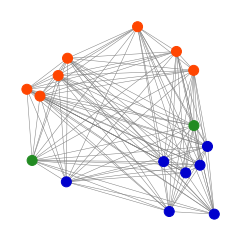

In [44]:
# --------------------------
# During Retrieve condition 
# --------------------------
cm = 1/2.54 
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

pos = nx.fruchterman_reingold_layout(ret_graph, weight='coupling_strength',k = 0.01)

edges = ret_graph.edges()
weights = [ret_graph[u][v]['coupling_strength'] for u,v in edges]

node_colors = np.array(['mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue',
                         'orangered','orangered','orangered','orangered','orangered','orangered','orangered',
                         'forestgreen','forestgreen'])


roi_order = {'0': 'mPFC','1': 'rAG','2': 'Precuneus','3': 'lAG1','4': 'PCC','5': 'MTG','6': 'lAG2','7': 'rITG',
             '8': 'rLOC','9': 'rPFC','10': 'lPFC1','11': 'SFG','12': 'lPFC2','13': 'lLOC','14': 'RSC2','15': 'RSC1'}
plt.figure(figsize=(8*cm,8*cm)) 
nx.draw(ret_graph, pos,  width=0.5, with_labels = False, node_size = 100, labels = roi_order,
        font_size=20, edge_color = "gray", node_color = node_colors, font_family = 'serif')
plt.show()


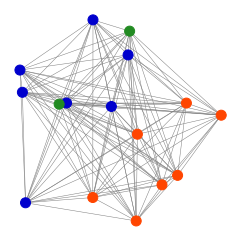

In [63]:
# --------------------------
# During perceive condition 
# --------------------------
cm = 1/2.54 
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

pos = nx.fruchterman_reingold_layout(per_graph, weight='coupling_strength',k = 0.01)

edges = per_graph.edges()
weights = [per_graph[u][v]['coupling_strength'] for u,v in edges]

node_colors = np.array(['mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue',
                         'orangered','orangered','orangered','orangered','orangered','orangered','orangered',
                         'forestgreen','forestgreen'])


roi_order = {'0': 'mPFC','1': 'rAG','2': 'Precuneus','3': 'lAG1','4': 'PCC','5': 'MTG','6': 'lAG2','7': 'rITG',
             '8': 'rLOC','9': 'rPFC','10': 'lPFC1','11': 'SFG','12': 'lPFC2','13': 'lLOC','14': 'RSC2','15': 'RSC1'}
plt.figure(figsize=(8*cm,8*cm)) 
nx.draw(per_graph, pos,  width=0.5, with_labels = False, node_size = 100, labels = roi_order,
        font_size=20, edge_color = "gray", node_color = node_colors, font_family = 'serif')
plt.show()

### Projecting functional community distance during Scramble

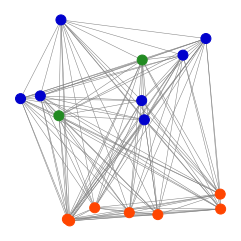

In [66]:
# --------------------------
# During scramble condition 
# --------------------------
cm = 1/2.54 
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

pos = nx.fruchterman_reingold_layout(scramble_graph, weight='coupling_strength',k = 0.01)

edges = scramble_graph.edges()
weights = [scramble_graph[u][v]['coupling_strength'] for u,v in edges]

node_colors = np.array(['mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue',
                         'orangered','orangered','orangered','orangered','orangered','orangered','orangered',
                         'forestgreen','forestgreen'])


roi_order = {'0': 'mPFC','1': 'rAG','2': 'Precuneus','3': 'lAG1','4': 'PCC','5': 'MTG','6': 'lAG2','7': 'rITG',
             '8': 'rLOC','9': 'rPFC','10': 'lPFC1','11': 'SFG','12': 'lPFC2','13': 'lLOC','14': 'RSC2','15': 'RSC1'}
plt.figure(figsize=(8*cm,8*cm)) 
nx.draw(scramble_graph, pos,  width=0.5, with_labels = False, node_size = 100, labels = roi_order,
        font_size=20, edge_color = "gray", node_color = node_colors, font_family = 'serif')
plt.show()